# Фаза 2 • Неделя 10 • Понедельник
## Обработка естественного языка
### Рекуррентные нейронные сети • RNN & LSTM

In [1]:
# !python3 -m venv .venv
# !source .venv/bin/activate
# !pip install --upgrade pip
# !uv pip install pandas matplotlib seaborn numpy

In [2]:
# !pip3 install torch torchvision #для cuda 12.8

In [3]:
# !uv pip install nltk torchutils torchmetrics
# !uv pip install mlflow

In [4]:
# !uv pip install scikit-learn

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re
import string
from collections import Counter
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torchutils as tu
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryPrecision,
    BinaryRecall,
    BinaryF1Score,
)
import multiprocessing as mp
from dataclasses import dataclass
from typing import Union
from tqdm.auto import tqdm
import mlflow
from time import time

/mnt/data/elbrus/Phase2_continue/ds-phase-2-cont-git/week3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
if __name__ == "__main__":
    mp.set_start_method("spawn", force=True)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# GENERATOR = (
#     torch.Generator(device=DEVICE) if torch.cuda.is_available() else torch.Generator()
# )
GENERATOR = torch.Generator()

use_mlflow = True
mlflow.set_tracking_uri("http://localhost:5000")

plt.rcParams["figure.dpi"] = 200
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [8]:
# !nvidia-smi

In [9]:
df = pd.read_csv("data/imdb.csv")
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [10]:
def data_preprocessing(text: str) -> str:
    """preprocessing string: lowercase, removing html-tags, punctuation and stopwords

    Args:
        text (str): input string for preprocessing

    Returns:
        str: preprocessed string
    """

    text = text.lower()
    text = re.sub("<.*?>", "", text)  # html tags
    text = "".join(
        [c for c in text if c not in string.punctuation]
    )  # Remove punctuation
    text = [word for word in text.split() if word not in stop_words]
    text = " ".join(text)
    return text


df["cleaned_reviews"] = df["review"].apply(data_preprocessing)

In [11]:
corpus = [word for text in df["cleaned_reviews"] for word in text.split()]
count_words = Counter(corpus)

sorted_words = count_words.most_common()

In [12]:
def get_words_by_freq(sorted_words: list, n: int = 10) -> list:
    return list(filter(lambda x: x[1] > n, sorted_words))

In [13]:
vocab_to_int = {w: i + 1 for i, (w, c) in enumerate(sorted_words)}

In [14]:
reviews_int = []
for text in df["cleaned_reviews"]:

    r = [vocab_to_int[word] for word in text.split() if vocab_to_int.get(word)]
    reviews_int.append(r)

In [15]:
df["sentiment"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)

In [16]:
review_len = [len(x) for x in reviews_int]
df["Review len"] = review_len
df.head()

review  sentiment  \
0  One of the other reviewers has mentioned that ...          1   
1  A wonderful little production. <br /><br />The...          1   
2  I thought this was a wonderful way to spend ti...          1   
3  Basically there's a family where a little boy ...          0   
4  Petter Mattei's "Love in the Time of Money" is...          1   

                                     cleaned_reviews  Review len  
0  one reviewers mentioned watching 1 oz episode ...         168  
1  wonderful little production filming technique ...          84  
2  thought wonderful way spend time hot summer we...          86  
3  basically theres family little boy jake thinks...          67  
4  petter matteis love time money visually stunni...         125

In [17]:
df.shape

(50000, 4)

In [18]:
reviews_int

[[3,
  1809,
  941,
  56,
  398,
  3216,
  286,
  349,
  3024,
  107,
  482,
  471,
  7412,
  19,
  57,
  3097,
  3216,
  5384,
  14831,
  50,
  473,
  180,
  107,
  549,
  52,
  1605,
  41,
  8024,
  5580,
  11453,
  41,
  2358,
  5834,
  5492,
  1339,
  276,
  473,
  3259,
  246,
  233,
  60896,
  353,
  3216,
  11120,
  240,
  15438,
  6674,
  2418,
  939,
  60897,
  2482,
  1247,
  24496,
  422,
  4557,
  2375,
  1080,
  6877,
  2828,
  12558,
  298,
  60898,
  16892,
  213,
  4901,
  3569,
  422,
  236,
  83230,
  8153,
  39824,
  14832,
  4989,
  7605,
  2318,
  16893,
  60899,
  224,
  8951,
  7194,
  12973,
  8403,
  33774,
  34,
  126,
  21145,
  7,
  45,
  166,
  1173,
  41,
  551,
  91,
  159,
  154,
  436,
  2842,
  704,
  84,
  1144,
  4165,
  2352,
  975,
  704,
  1282,
  704,
  83231,
  58,
  853,
  87,
  19,
  286,
  43,
  103,
  3097,
  1451,
  2067,
  288,
  45,
  1422,
  174,
  1336,
  1122,
  3216,
  88,
  9930,
  213,
  1949,
  1961,
  473,
  473,
  7674,
  6878,
 

In [19]:
def padding(review_int: list, seq_len: int) -> np.array:
    """Make left-sided padding for input list of tokens

    Args:
        review_int (list): input list of tokens
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros

    Returns:
        np.array: padded sequences
    """
    features = np.zeros((len(reviews_int), seq_len), dtype=int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[:seq_len]
        features[i, :] = np.array(new)

    return features

In [20]:
def preprocess_single_string(
    input_string: str, seq_len: int, vocab_to_int: dict = vocab_to_int
) -> list:
    """Function for all preprocessing steps on a single string

    Args:
        input_string (str): input single string for preprocessing
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros
        vocab_to_int (dict, optional): word corpus {'word' : int index}. Defaults to vocab_to_int.

    Returns:
        list: preprocessed string
    """

    preprocessed_string = data_preprocessing(input_string)
    result_list = []
    for word in preprocessed_string.split():
        try:
            result_list.append(vocab_to_int[word])
        except KeyError as e:
            print(f"{e}: not in dictionary!")
    result_padded = padding([result_list], seq_len)[0]

    return torch.tensor(result_padded)

In [21]:
SEQ_LEN = 32
features = padding(reviews_int, SEQ_LEN)
print(len(features[3, :]) != 32)

False


In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, df["sentiment"].to_numpy(), test_size=0.2, random_state=1
)

In [23]:
X_train.shape
X_valid.shape

(10000, 32)

In [24]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))


BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)
valid_loader = DataLoader(
    valid_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)

In [25]:
VOCAB_SIZE = len(vocab_to_int) + 1

In [26]:
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

In [27]:
sample_x.shape

torch.Size([32, 32])

PyTorch: [docs](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

#### Задание 1

Создай модель со следующими параметрами и примени `get_model_summary`: 
- два RNN-слоя (это параметр в слое, а не отдельные компоненты сети)
- 32 - размер hidden state
- 16 - размер эмбеддинг-слоя 

In [28]:
@dataclass
class ConfigRNN:
    n_layers: int
    embedding_size: int
    hidden_size: int
    vocab_size: int = VOCAB_SIZE
    device: str = DEVICE
    seq_len: int = SEQ_LEN
    bidirectional: Union[bool, int] = False


rnn_config = ConfigRNN(
    n_layers=2, embedding_size=16, hidden_size=32, bidirectional=False
)

In [29]:
class RNN(nn.Module):
    """
    vocab_size: int, размер словаря (аргумент embedding-слоя)
    emb_size:   int, размер вектора для описания каждого элемента последовательности
    hidden_dim: int, размер вектора скрытого состояния, default 0
    batch_size: int, размер batch
    n_layers:   int, количество слоев
    """

    def __init__(self, rnn_config=rnn_config) -> None:
        super().__init__()
        # инициализируем конфиг
        self.rnn_config = rnn_config
        self.seq_len = self.rnn_config.seq_len
        self.vocab_size = self.rnn_config.vocab_size
        self.hidden_size = self.rnn_config.hidden_size
        self.emb_size = self.rnn_config.embedding_size
        self.n_layers = self.rnn_config.n_layers
        self.device = self.rnn_config.device
        self.bidirectional = bool(self.rnn_config.bidirectional)

        self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
        self.rnn_cell = nn.RNN(
            input_size=self.emb_size,
            hidden_size=self.hidden_size,
            batch_first=True,
            bidirectional=self.bidirectional,
            num_layers=self.n_layers,
            device=self.device,
        )

        self.bidirect_factor = 2 if self.bidirectional == 1 else 1

        self.linear = nn.Sequential(
            nn.Linear(self.hidden_size * self.seq_len * self.bidirect_factor, 16),
            nn.Tanh(),
            nn.Linear(16, 1),
        )

    def model_description(self):
        direction = "bidirect" if self.bidirectional else "onedirect"
        return f"rnn_{direction}_{self.n_layers}"

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x.to(self.device))
        output, _ = self.rnn_cell(
            x
        )  # Забираем hidden states со всех промежуточных состояний, второй выход отправляем в _
        # print(f"Shape after rnn_cell: {output.shape}")
        output = output.contiguous().view(output.size(0), -1)
        # print(f"Shape before linear: {output.shape}")
        out = self.linear(output)
        return out

In [30]:
model_rnn = RNN(rnn_config=rnn_config).to(DEVICE)

In [31]:
tu.get_model_summary(model_rnn, sample_x.to(rnn_config.device))

Layer                  Kernel         Output       Params          FLOPs
0_embedding         [16, 222610]   [32, 32, 16]   3,561,760        1,024
1_rnn_cell                     -   [32, 32, 32]       3,712   31,784,960
2_linear.Linear_0     [1024, 16]       [32, 16]      16,400    1,048,064
3_linear.Tanh_1                -       [32, 16]           0        2,560
4_linear.Linear_2        [16, 1]        [32, 1]          17          992
Total params: 3,581,889
Trainable params: 3,581,889
Non-trainable params: 0
Total FLOPs: 32,837,600 / 32.84 MFLOPs
------------------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.38
Params size (MB): 13.66
Estimated Total Size (MB): 14.05


Задай функцию потерь, оптимизаторы и реализуй обучающий цикл. 
В цикле: 
* сохраняй промежуточные веса модели, чтобы потом не терять время на новом обучении
* замеряй время обучения текущей модели для сравнения с LSTM-моделью
* зафиксируй число эпох: 7-10 (в зависимости от ресурсов компьютера)

In [32]:
# оптимизатор, функция потерь, метрика
LR = 3e-4
criterion = nn.BCEWithLogitsLoss()
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=LR, weight_decay=1e-4)
acc = BinaryAccuracy().to(DEVICE)
prec = BinaryPrecision().to(DEVICE)
rec = BinaryRecall().to(DEVICE)
f1 = BinaryF1Score().to(DEVICE)

In [33]:
def binary_metrics(outputs, labels, threshold=0.5):
    # Если 2 канала на выходе
    # if outputs.shape[1] == 2:
    #     preds = torch.argmax(outputs, dim=1)
    # else:  # 1 канал
    #     preds = (torch.sigmoid(outputs) > threshold).float()

    # labels = labels.squeeze(1)  # на случай [B,1,H,W]

    preds = outputs.squeeze().float()
    labels = labels.float()
    return (
        acc(preds, labels).item(),
        prec(preds, labels).item(),
        rec(preds, labels).item(),
        f1(preds, labels).item(),
    )
    # # Accuracy
    # acc = (preds == labels).float().mean()

    # tp = (preds == labels > 0.5).sum()
    # tn = (preds == labels < 0.5).sum()
    # fp = (preds != labels > 0.5).sum()
    # fn = (preds != labels < 0.5).sum()

    # # precision

    # prec = tp / (tp + fp)

    # # recall

    # rec = tp / (tp + fn)

    # # f1

    # f1 = 2 * prec * rec / (prec + rec)

    # return acc.item(), prec.item(), rec.item(), f1.item()

In [34]:
# цикл обучения и валидации
def fit_model(
    epochs: int,
    model: nn.Module,
    model_name: str,
    optimizer: torch.optim.Optimizer,
    criterion=criterion,
    train_loader=train_loader,
    valid_loader=valid_loader,
):

    log = dict()
    log["train_loss"] = []
    log["valid_loss"] = []
    log["train_accuracy"] = []
    log["valid_accuracy"] = []
    log["train_precision"] = []
    log["valid_precision"] = []
    log["train_recall"] = []
    log["valid_recall"] = []
    log["train_f1"] = []
    log["valid_f1"] = []

    time_start = time()

    start_epoch = len(log["train_loss"])

    ### Создаем папку для записи весов
    # -----------------------------------------------------------------
    # Создаём корневую папку weights, если её нет
    folder_path = f"weights/"
    model_folder_path = os.path.join(folder_path, f"{model_name}")

    os.makedirs(model_folder_path, exist_ok=True)

    # Список номеров run_*
    run_nums = []

    # Ищем все подпапки с именем run_число
    for item_name in os.listdir(model_folder_path):
        full_path = os.path.join(model_folder_path, item_name)
        if os.path.isdir(full_path):
            match = re.search(r"run_(\d+)", item_name)
            if match:
                run_nums.append(int(match.group(1)))

    # Определяем следующий номер
    run = max(run_nums) + 1 if run_nums else 1

    # Создаём новую папку
    new_folder = os.path.join(model_folder_path, f"run_{run}")
    os.makedirs(new_folder, exist_ok=True)
    # -----------------------------------------------------------------

    ### Цикл обучения
    # -----------------------------------------------------------------
    for epoch in range(start_epoch + 1, start_epoch + epochs + 1):

        curr_run_path = os.path.join(folder_path, model_name, f"run_{run}")

        epoch_time_start = time()

        print(f'{"-"*13} Epoch {epoch} {"-"*13}')

        ### Обучение

        batch_acc = []
        batch_prec = []
        batch_recall = []
        batch_loss = []
        batch_f1 = []

        model.train()

        # Прогресс бар

        train_pbar = tqdm(
            train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=True
        )

        for inputs, labels in train_pbar:

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            # Функции потерь

            outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels.float())
            batch_loss.append(loss.item())

            # Метрики
            acc, prec, rec, f1 = binary_metrics(outputs, labels)

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_recall.append(rec)
            batch_f1.append(f1)

            loss.backward()
            optimizer.step()

        train_pbar.set_postfix(
            {
                "Loss": loss,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1-score": f1,
            }
        )

        log["train_loss"].append(np.mean(batch_loss))
        log["train_accuracy"].append(np.mean(batch_acc))
        log["train_precision"].append(np.mean(batch_prec))
        log["train_recall"].append(np.mean(batch_recall))
        log["train_f1"].append(np.mean(batch_f1))

        ### Валидация

        batch_acc = []
        batch_prec = []
        batch_recall = []
        batch_loss = []
        batch_f1 = []

        model.eval()

        valid_pbar = tqdm(
            valid_loader, desc=f"Epoch {epoch}/{epochs} [Test]", leave=True
        )
        for inputs, labels in valid_pbar:

            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            with torch.no_grad():
                outputs = model(inputs).squeeze()

            loss = criterion(outputs, labels.float())
            batch_loss.append(loss.item())

            # Метрики
            acc, prec, rec, f1 = binary_metrics(outputs, labels)

            batch_acc.append(acc)
            batch_prec.append(prec)
            batch_recall.append(rec)
            batch_f1.append(f1)

        valid_pbar.set_postfix(
            {
                "Loss": loss,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1-score": f1,
            }
        )
        ### Метрики и логирование

        log["valid_loss"].append(np.mean(batch_loss))
        log["valid_accuracy"].append(np.mean(batch_acc))
        log["valid_precision"].append(np.mean(batch_prec))
        log["valid_recall"].append(np.mean(batch_recall))
        log["valid_f1"].append(np.mean(batch_f1))

        # [MLflow] Логируем метрики
        if use_mlflow:
            # epoch – номер шага (можно указывать step=epoch)
            for c in log.keys():
                mlflow.log_metric(c, log[c][-1], step=epoch)
            # mlflow.log_metric("train_loss", log["train_loss"][-1], step=epoch)
            # mlflow.log_metric("train_accuracy", log["train_accuracy"][-1], step=epoch)
            # mlflow.log_metric("train_precision", log["train_precision"][-1], step=epoch)
            # mlflow.log_metric("train_recall", log["train_recall"][-1], step=epoch)
            # mlflow.log_metric("train_f1", log["train_f1"][-1], step=epoch)
            # mlflow.log_metric("valid_loss", log["valid_loss"][-1], step=epoch)
            # mlflow.log_metric("valid_accuracy", log["valid_accuracy"][-1], step=epoch)
            # mlflow.log_metric("valid_dice", log["valid_dice"][-1], step=epoch)
            # mlflow.log_metric("valid_iou", log["valid_iou"][-1], step=epoch)
        epoch_time = time() - epoch_time_start
        # Train stage
        print(
            f"Train stage: "
            f"loss: {log['train_loss'][-1]:>6.3f}  "
            f"Accuracy: {log['train_accuracy'][-1]:>6.3f}  "
            f"Precision: {log['train_precision'][-1]:>6.3f}  "
            f"Recall: {log['train_recall'][-1]:>6.3f}  "
            f"F1-score: {log['train_f1'][-1]:>6.3f}  "
        )

        # Valid stage
        print(
            f"Valid stage: "
            f"loss: {log['valid_loss'][-1]:>6.3f}  "
            f"Accuracy: {log['valid_accuracy'][-1]:>6.3f}  "
            f"Precision: {log['valid_precision'][-1]:>6.3f}  "
            f"Recall: {log['valid_recall'][-1]:>6.3f}  "
            f"F1-score: {log['valid_f1'][-1]:>6.3f}  "
        )
        print(f"Time: {epoch_time}")

        print(f'{"-"*35}\n')
        torch.save(
            model.state_dict(), os.path.join(curr_run_path, f"weight_epoch_{epoch}.pth")
        )

    total_training_time = time() - time_start
    print(f"Total time = {total_training_time:>5.1f} сек")
    # -----------------------------------------------------------------

    return log, total_training_time, run

In [35]:
def fit_with_mlflow(
    model,
    model_name,
    epochs,
    optimizer,
    experiment_name,
    criterion=criterion,
    train_loader=train_loader,
    valid_loader=valid_loader,
):
    mlflow.set_experiment(experiment_name)  # установить (или создать) эксперимент
    with mlflow.start_run(run_name=f"{experiment_name}_BS = {BATCH_SIZE}_lr_{LR}"):
        # Логируем гиперпараметры из config
        mlflow.log_param("batch_size", BATCH_SIZE)
        mlflow.log_param("learning_rate", LR)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("device", DEVICE)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("criterion", criterion)

        mlflow.pytorch.autolog(
            checkpoint=True,
            checkpoint_save_best_only=False,
            checkpoint_save_weights_only=True,
            checkpoint_save_freq="epoch",
        )
        # mlflow.log_param("augmentation", ("Yes" if augmentation else "No"))
        print("начало обучения...")
        # Запускаем обучение
        logs, tot_time, run = fit_model(
            model=model,
            model_name=model_name,
            epochs=epochs,
            optimizer=optimizer,
            criterion=criterion,
            train_loader=train_loader,
            valid_loader=valid_loader,
        )
        mlflow.log_param("Total time", tot_time)

        # Сохраняем модель в MLflow (опционально)
        # mlflow.pytorch.log_model(base_cnn, "model")

    # После выхода из `with` Run автоматически завершается
    return logs, tot_time, run

In [36]:
logs, train_time, run = fit_with_mlflow(
    model=model_rnn,
    model_name="RNN",
    epochs=10,
    optimizer=optimizer_rnn,
    experiment_name="RNN",
    criterion=criterion,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

начало обучения...
------------- Epoch 1 -------------


Epoch 1/10 [Test]: 100%|██████████| 312/312 [00:02<00:00, 106.07it/s]


Train stage: loss:  0.684  Accuracy:  0.547  Precision:  0.550  Recall:  0.542  F1-score:  0.517  
Valid stage: loss:  0.666  Accuracy:  0.592  Precision:  0.598  Recall:  0.541  F1-score:  0.559  
Time: 13.35374402999878
-----------------------------------

------------- Epoch 2 -------------


Epoch 2/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 89.62it/s] 


Train stage: loss:  0.634  Accuracy:  0.638  Precision:  0.637  Recall:  0.653  F1-score:  0.634  
Valid stage: loss:  0.612  Accuracy:  0.664  Precision:  0.645  Recall:  0.718  F1-score:  0.673  
Time: 14.70202088356018
-----------------------------------

------------- Epoch 3 -------------


Epoch 3/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 90.84it/s] 


Train stage: loss:  0.567  Accuracy:  0.707  Precision:  0.701  Recall:  0.726  F1-score:  0.705  
Valid stage: loss:  0.562  Accuracy:  0.707  Precision:  0.715  Recall:  0.680  F1-score:  0.689  
Time: 14.547030687332153
-----------------------------------

------------- Epoch 4 -------------


Epoch 4/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 84.54it/s] 


Train stage: loss:  0.508  Accuracy:  0.751  Precision:  0.744  Recall:  0.769  F1-score:  0.749  
Valid stage: loss:  0.523  Accuracy:  0.739  Precision:  0.713  Recall:  0.794  F1-score:  0.746  
Time: 14.867603302001953
-----------------------------------

------------- Epoch 5 -------------


Epoch 5/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 82.33it/s] 


Train stage: loss:  0.462  Accuracy:  0.785  Precision:  0.779  Recall:  0.802  F1-score:  0.783  
Valid stage: loss:  0.499  Accuracy:  0.758  Precision:  0.755  Recall:  0.757  F1-score:  0.750  
Time: 15.027387380599976
-----------------------------------

------------- Epoch 6 -------------


Epoch 6/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 88.62it/s] 


Train stage: loss:  0.422  Accuracy:  0.812  Precision:  0.805  Recall:  0.826  F1-score:  0.810  
Valid stage: loss:  0.485  Accuracy:  0.772  Precision:  0.765  Recall:  0.783  F1-score:  0.768  
Time: 15.048094034194946
-----------------------------------

------------- Epoch 7 -------------


Epoch 7/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 75.63it/s] 


Train stage: loss:  0.386  Accuracy:  0.835  Precision:  0.830  Recall:  0.844  F1-score:  0.832  
Valid stage: loss:  0.471  Accuracy:  0.779  Precision:  0.772  Recall:  0.782  F1-score:  0.772  
Time: 14.785526752471924
-----------------------------------

------------- Epoch 8 -------------


Epoch 8/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 89.81it/s] 


Train stage: loss:  0.352  Accuracy:  0.853  Precision:  0.847  Recall:  0.862  F1-score:  0.850  
Valid stage: loss:  0.481  Accuracy:  0.787  Precision:  0.772  Recall:  0.815  F1-score:  0.787  
Time: 14.714255332946777
-----------------------------------

------------- Epoch 9 -------------


Epoch 9/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 87.83it/s] 


Train stage: loss:  0.321  Accuracy:  0.870  Precision:  0.867  Recall:  0.877  F1-score:  0.868  
Valid stage: loss:  0.477  Accuracy:  0.791  Precision:  0.800  Recall:  0.770  F1-score:  0.780  
Time: 14.512041807174683
-----------------------------------

------------- Epoch 10 -------------


Epoch 10/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 86.44it/s] 


Train stage: loss:  0.288  Accuracy:  0.889  Precision:  0.887  Recall:  0.893  F1-score:  0.886  
Valid stage: loss:  0.492  Accuracy:  0.793  Precision:  0.796  Recall:  0.784  F1-score:  0.784  
Time: 15.2747220993042
-----------------------------------

Total time = 146.9 сек
🏃 View run RNN_BS = 32_lr_0.0003 at: http://localhost:5000/#/experiments/999546781598540586/runs/cbf4deddd24c4f8eb4739333f7e6459e
🧪 View experiment at: http://localhost:5000/#/experiments/999546781598540586


Распечатай кривые обучения и изменения метрики. 

In [37]:
def plot_history(history, grid=True, suptitle="model 1"):
    fig, ax = plt.subplots(3, 2, figsize=(16, 20))
    fig.suptitle(suptitle, fontsize=24, fontweight="bold", y=0.85)
    ax[0][0].plot(history["train_loss"], label="train loss")
    ax[0][0].plot(history["valid_loss"], label="valid loss")
    ax[0][0].set_title(f'Loss on epoch {len(history["train_loss"])}', fontsize=16)
    ax[0][0].grid(grid)
    ax[0][0].set_ylim((0, max(history["train_loss"] + history["valid_loss"]) + 0.1))
    ax[0][0].legend(fontsize=14)
    ax[0][0].set_xlabel("Epoch", fontsize=14)
    ax[0][0].set_ylabel("Loss", fontsize=14)

    ax[0][1].plot(history["train_accuracy"], label="train accuracy")
    ax[0][1].plot(history["valid_accuracy"], label="valid accuracy")
    ax[0][1].set_title(f'Accuracy on epoch {len(history["train_loss"])}', fontsize=16)
    ax[0][1].grid(grid)
    # ax[0][1].set_ylim((min(history["train_accuracy"]) - 0.05, 1))
    ax[0][1].set_ylim(0.5, 1)
    ax[0][1].legend(fontsize=14)
    ax[0][1].set_xlabel("Epoch", fontsize=14)
    ax[0][1].set_ylabel("Accuracy", fontsize=14)

    ax[1][0].plot(history["train_precision"], label="train precision")
    ax[1][0].plot(history["valid_precision"], label="valid precision")
    ax[1][0].set_title(f'Precision on epoch {len(history["train_loss"])}', fontsize=16)
    ax[1][0].grid(grid)
    ax[1][0].set_ylim(0.5, 1)
    # ax[1][0].set_ylim(min(history["train_precision"]) - 0.05, 1)
    ax[1][0].legend(fontsize=14)
    ax[1][0].set_xlabel("Epoch", fontsize=14)
    ax[1][0].set_ylabel("Precision", fontsize=14)

    ax[1][1].plot(history["train_recall"], label="train recall")
    ax[1][1].plot(history["valid_recall"], label="valid recall")
    ax[1][1].set_title(f'Recal on epoch {len(history["train_loss"])}', fontsize=16)
    ax[1][1].grid(grid)
    ax[1][1].set_ylim(0.5, 1)
    # ax[1][1].set_ylim((min(history["train_recall"]) - 0.05, 1))
    ax[1][1].legend(fontsize=14)
    ax[1][1].set_xlabel("Epoch", fontsize=14)
    ax[1][1].set_ylabel("Recal", fontsize=14)

    ax[2][0].plot(history["train_f1"], label="train f1")
    ax[2][0].plot(history["valid_f1"], label="valid f1")
    ax[2][0].set_title(f'F1-score on epoch {len(history["train_loss"])}', fontsize=16)
    ax[2][0].grid(grid)
    ax[2][0].set_ylim(0.5, 1)
    # ax[2][0].set_ylim((min(history["train_f1"]) - 0.05, 1))
    ax[2][0].legend(fontsize=14)
    ax[2][0].set_xlabel("Epoch", fontsize=14)
    ax[2][0].set_ylabel("F1", fontsize=14)
    plt.subplots_adjust(top=0.8)
    # plt.tight_layout(rect=[0, 0, 1, 0.8])
    plt.show()
    return fig

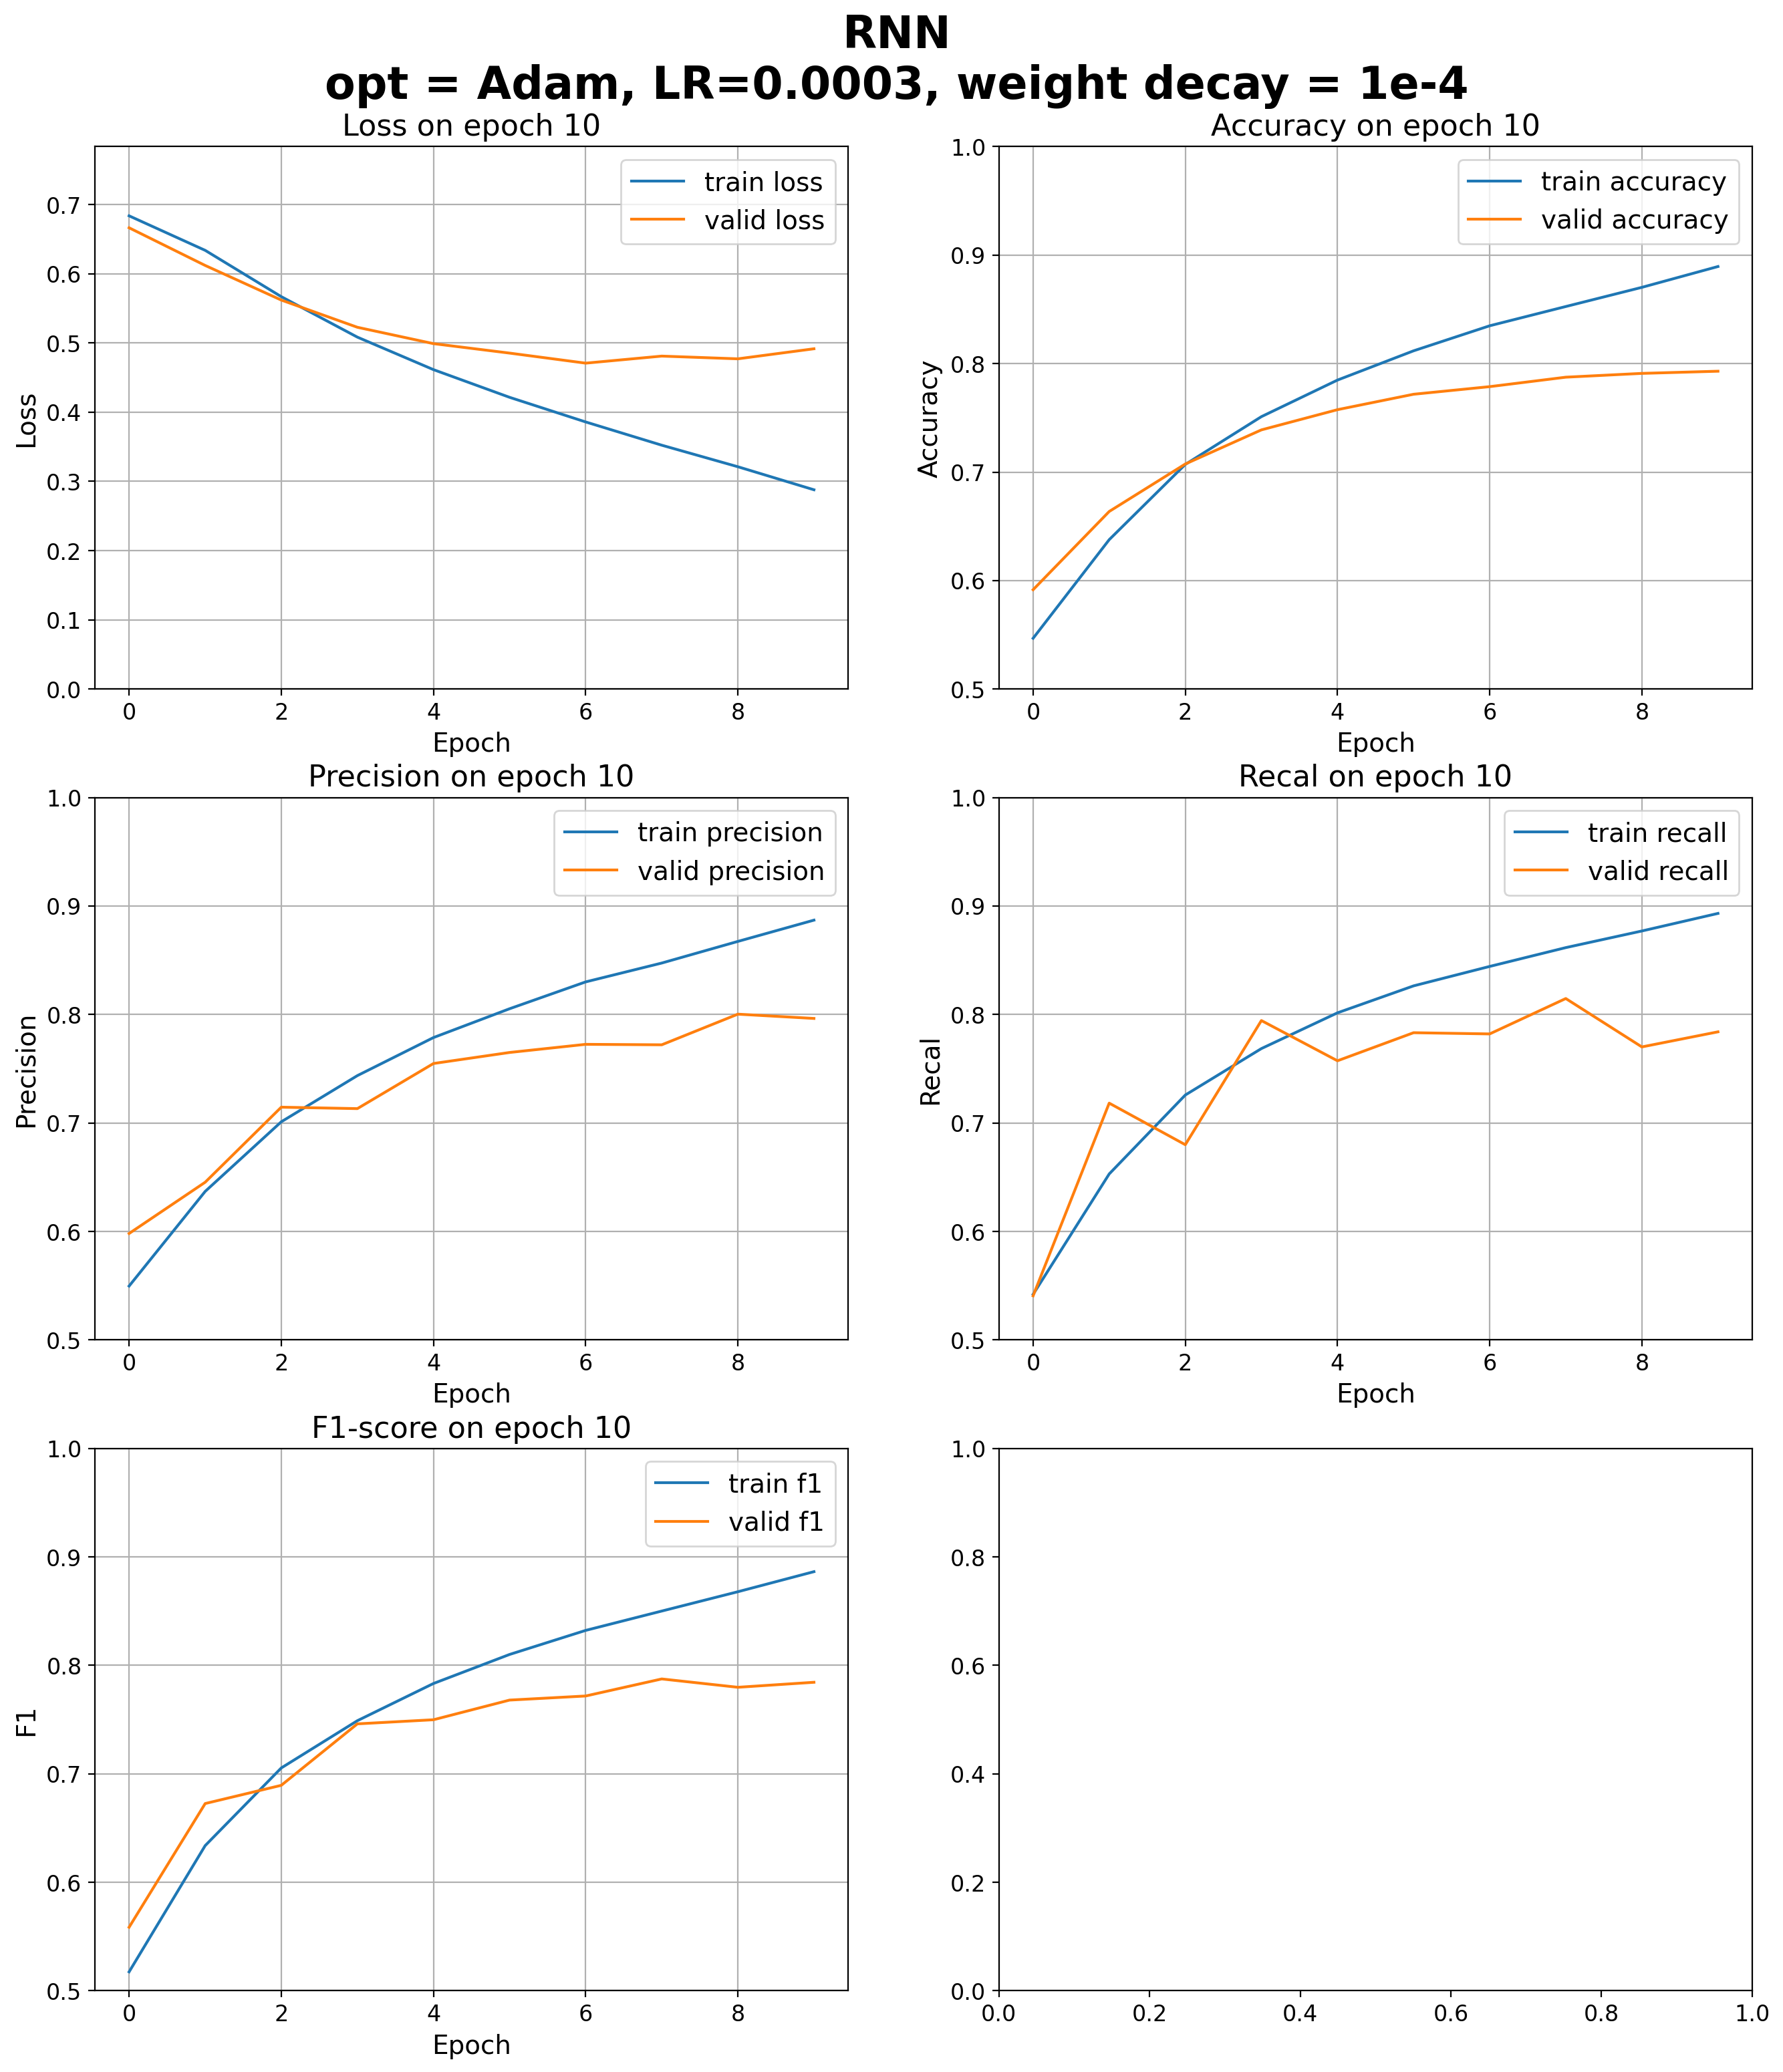

In [71]:
fig = plot_history(logs, suptitle=f"RNN\nopt = Adam, LR={LR}, weight decay = 1e-4")

In [ ]:
# fig.savefig(f"results/RNN_run_{run}_metrics_with_l2.png", bbox_inches="tight")

Сохрани модель и историю изменения лоссов и метрик. 

In [ ]:
pass

#### Задание 2

Создай двунаправленную двуслойную LSTM-сеть и реши задачу классификации. 

Распечатай кривые обучения обеих моделей и значения метрик во время обучения. Примерный результат должен выглядеть так (с поправкой на твою архитектуру в заголовке):

![](aux/10-01-results.png)

Отправь полученный график в канал группы в Slack!

In [42]:
@dataclass
class ConfigLSTM:
    n_layers: int
    embedding_size: int
    hidden_size: int
    vocab_size: int = VOCAB_SIZE
    device: str = DEVICE
    seq_len: int = SEQ_LEN
    bidirectional: Union[bool, int] = False


lstm_config = ConfigLSTM(
    n_layers=2, embedding_size=16, hidden_size=32, bidirectional=True
)

In [47]:
class LSTMClassifier(nn.Module):
    def __init__(self, lstm_conf=lstm_config) -> None:
        super().__init__()

        self.embedding_dim = lstm_conf.embedding_size
        self.hidden_size = lstm_conf.hidden_size
        self.bidirectional = lstm_conf.bidirectional
        self.n_layers = lstm_conf.n_layers

        self.embedding = nn.Embedding(lstm_conf.vocab_size, self.embedding_dim)
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.hidden_size,
            bidirectional=self.bidirectional,
            batch_first=True,
            num_layers=self.n_layers,
        )
        self.bidirect_factor = 2 if self.bidirectional else 1
        self.clf = nn.Sequential(
            nn.Linear(self.hidden_size * self.bidirect_factor, 32),
            nn.Tanh(),
            nn.Dropout(),
            nn.Linear(32, 1),
        )

    def model_description(self):
        direction = "bidirect" if self.bidirectional else "onedirect"
        return f"lstm_{direction}_{self.n_layers}"

    def forward(self, x: torch.Tensor):
        embeddings = self.embedding(x)
        out, _ = self.lstm(embeddings)
        # print(out.shape)
        out = out[
            :, -1, :
        ]  # [все элементы батча, последний h_n, все элементы последнего h_n]
        # print(out.shape)
        out = self.clf(out)
        return out


model_lstm = LSTMClassifier(lstm_config)
tu.get_model_summary(model_lstm, sample_x)

Layer                Kernel         Output       Params           FLOPs
0_embedding       [16, 222610]   [32, 32, 16]   3,561,760         1,024
1_lstm                       -   [32, 32, 64]      37,888   217,317,376
2_clf.Linear_0        [64, 32]       [32, 32]       2,080       130,048
3_clf.Tanh_1                 -       [32, 32]           0         5,120
4_clf.Dropout_2              -       [32, 32]           0             0
5_clf.Linear_3         [32, 1]        [32, 1]          33         2,016
Total params: 3,601,761
Trainable params: 3,601,761
Non-trainable params: 0
Total FLOPs: 217,455,584 / 217.46 MFLOPs
-----------------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.65
Params size (MB): 13.74
Estimated Total Size (MB): 14.40


In [48]:
model_lstm = model_lstm.to(DEVICE)
LR_LSTM = 3e-4
criterion_lstm = nn.BCEWithLogitsLoss()
optimizer_lstm = torch.optim.Adam(
    model_lstm.parameters(), lr=LR_LSTM, weight_decay=1e-4
)

In [49]:
logs_lstm, train_time_lstm, run_lstm = fit_with_mlflow(
    model=model_lstm,
    model_name="LSTM",
    epochs=10,
    optimizer=optimizer_lstm,
    experiment_name="LSTM",
    criterion=criterion_lstm,
    train_loader=train_loader,
    valid_loader=valid_loader,
)

начало обучения...
------------- Epoch 1 -------------


Epoch 1/10 [Test]: 100%|██████████| 312/312 [00:02<00:00, 105.98it/s]


Train stage: loss:  0.693  Accuracy:  0.508  Precision:  0.507  Recall:  0.601  F1-score:  0.532  
Valid stage: loss:  0.692  Accuracy:  0.515  Precision:  0.510  Recall:  0.607  F1-score:  0.546  
Time: 15.536334991455078
-----------------------------------

------------- Epoch 2 -------------


Epoch 2/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 92.77it/s] 


Train stage: loss:  0.663  Accuracy:  0.592  Precision:  0.591  Recall:  0.610  F1-score:  0.586  
Valid stage: loss:  0.624  Accuracy:  0.650  Precision:  0.619  Recall:  0.773  F1-score:  0.682  
Time: 15.966828107833862
-----------------------------------

------------- Epoch 3 -------------


Epoch 3/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 90.55it/s] 


Train stage: loss:  0.577  Accuracy:  0.701  Precision:  0.688  Recall:  0.743  F1-score:  0.706  
Valid stage: loss:  0.558  Accuracy:  0.715  Precision:  0.707  Recall:  0.729  F1-score:  0.712  
Time: 15.873361349105835
-----------------------------------

------------- Epoch 4 -------------


Epoch 4/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 87.42it/s] 


Train stage: loss:  0.517  Accuracy:  0.748  Precision:  0.738  Recall:  0.775  F1-score:  0.748  
Valid stage: loss:  0.524  Accuracy:  0.737  Precision:  0.690  Recall:  0.851  F1-score:  0.756  
Time: 16.164631843566895
-----------------------------------

------------- Epoch 5 -------------


Epoch 5/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 92.42it/s] 


Train stage: loss:  0.469  Accuracy:  0.782  Precision:  0.773  Recall:  0.799  F1-score:  0.780  
Valid stage: loss:  0.485  Accuracy:  0.768  Precision:  0.775  Recall:  0.749  F1-score:  0.756  
Time: 15.625370502471924
-----------------------------------

------------- Epoch 6 -------------


Epoch 6/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 89.06it/s] 


Train stage: loss:  0.431  Accuracy:  0.805  Precision:  0.801  Recall:  0.816  F1-score:  0.803  
Valid stage: loss:  0.467  Accuracy:  0.777  Precision:  0.791  Recall:  0.749  F1-score:  0.763  
Time: 16.144404888153076
-----------------------------------

------------- Epoch 7 -------------


Epoch 7/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 84.90it/s] 


Train stage: loss:  0.398  Accuracy:  0.827  Precision:  0.826  Recall:  0.832  F1-score:  0.824  
Valid stage: loss:  0.458  Accuracy:  0.786  Precision:  0.797  Recall:  0.762  F1-score:  0.773  
Time: 16.169984102249146
-----------------------------------

------------- Epoch 8 -------------


Epoch 8/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 89.17it/s] 


Train stage: loss:  0.364  Accuracy:  0.847  Precision:  0.848  Recall:  0.849  F1-score:  0.844  
Valid stage: loss:  0.457  Accuracy:  0.795  Precision:  0.771  Recall:  0.836  F1-score:  0.797  
Time: 16.120303630828857
-----------------------------------

------------- Epoch 9 -------------


Epoch 9/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 87.23it/s] 


Train stage: loss:  0.332  Accuracy:  0.865  Precision:  0.866  Recall:  0.864  F1-score:  0.861  
Valid stage: loss:  0.468  Accuracy:  0.792  Precision:  0.822  Recall:  0.743  F1-score:  0.774  
Time: 16.024725914001465
-----------------------------------

------------- Epoch 10 -------------


Epoch 10/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 89.09it/s] 


Train stage: loss:  0.303  Accuracy:  0.882  Precision:  0.885  Recall:  0.878  F1-score:  0.878  
Valid stage: loss:  0.475  Accuracy:  0.801  Precision:  0.799  Recall:  0.797  F1-score:  0.794  
Time: 15.849056482315063
-----------------------------------

Total time = 159.6 сек
🏃 View run LSTM_BS = 32_lr_0.0003 at: http://localhost:5000/#/experiments/366147407291874077/runs/d0bcaf6bc03744d28e58dbba1b42a3ba
🧪 View experiment at: http://localhost:5000/#/experiments/366147407291874077


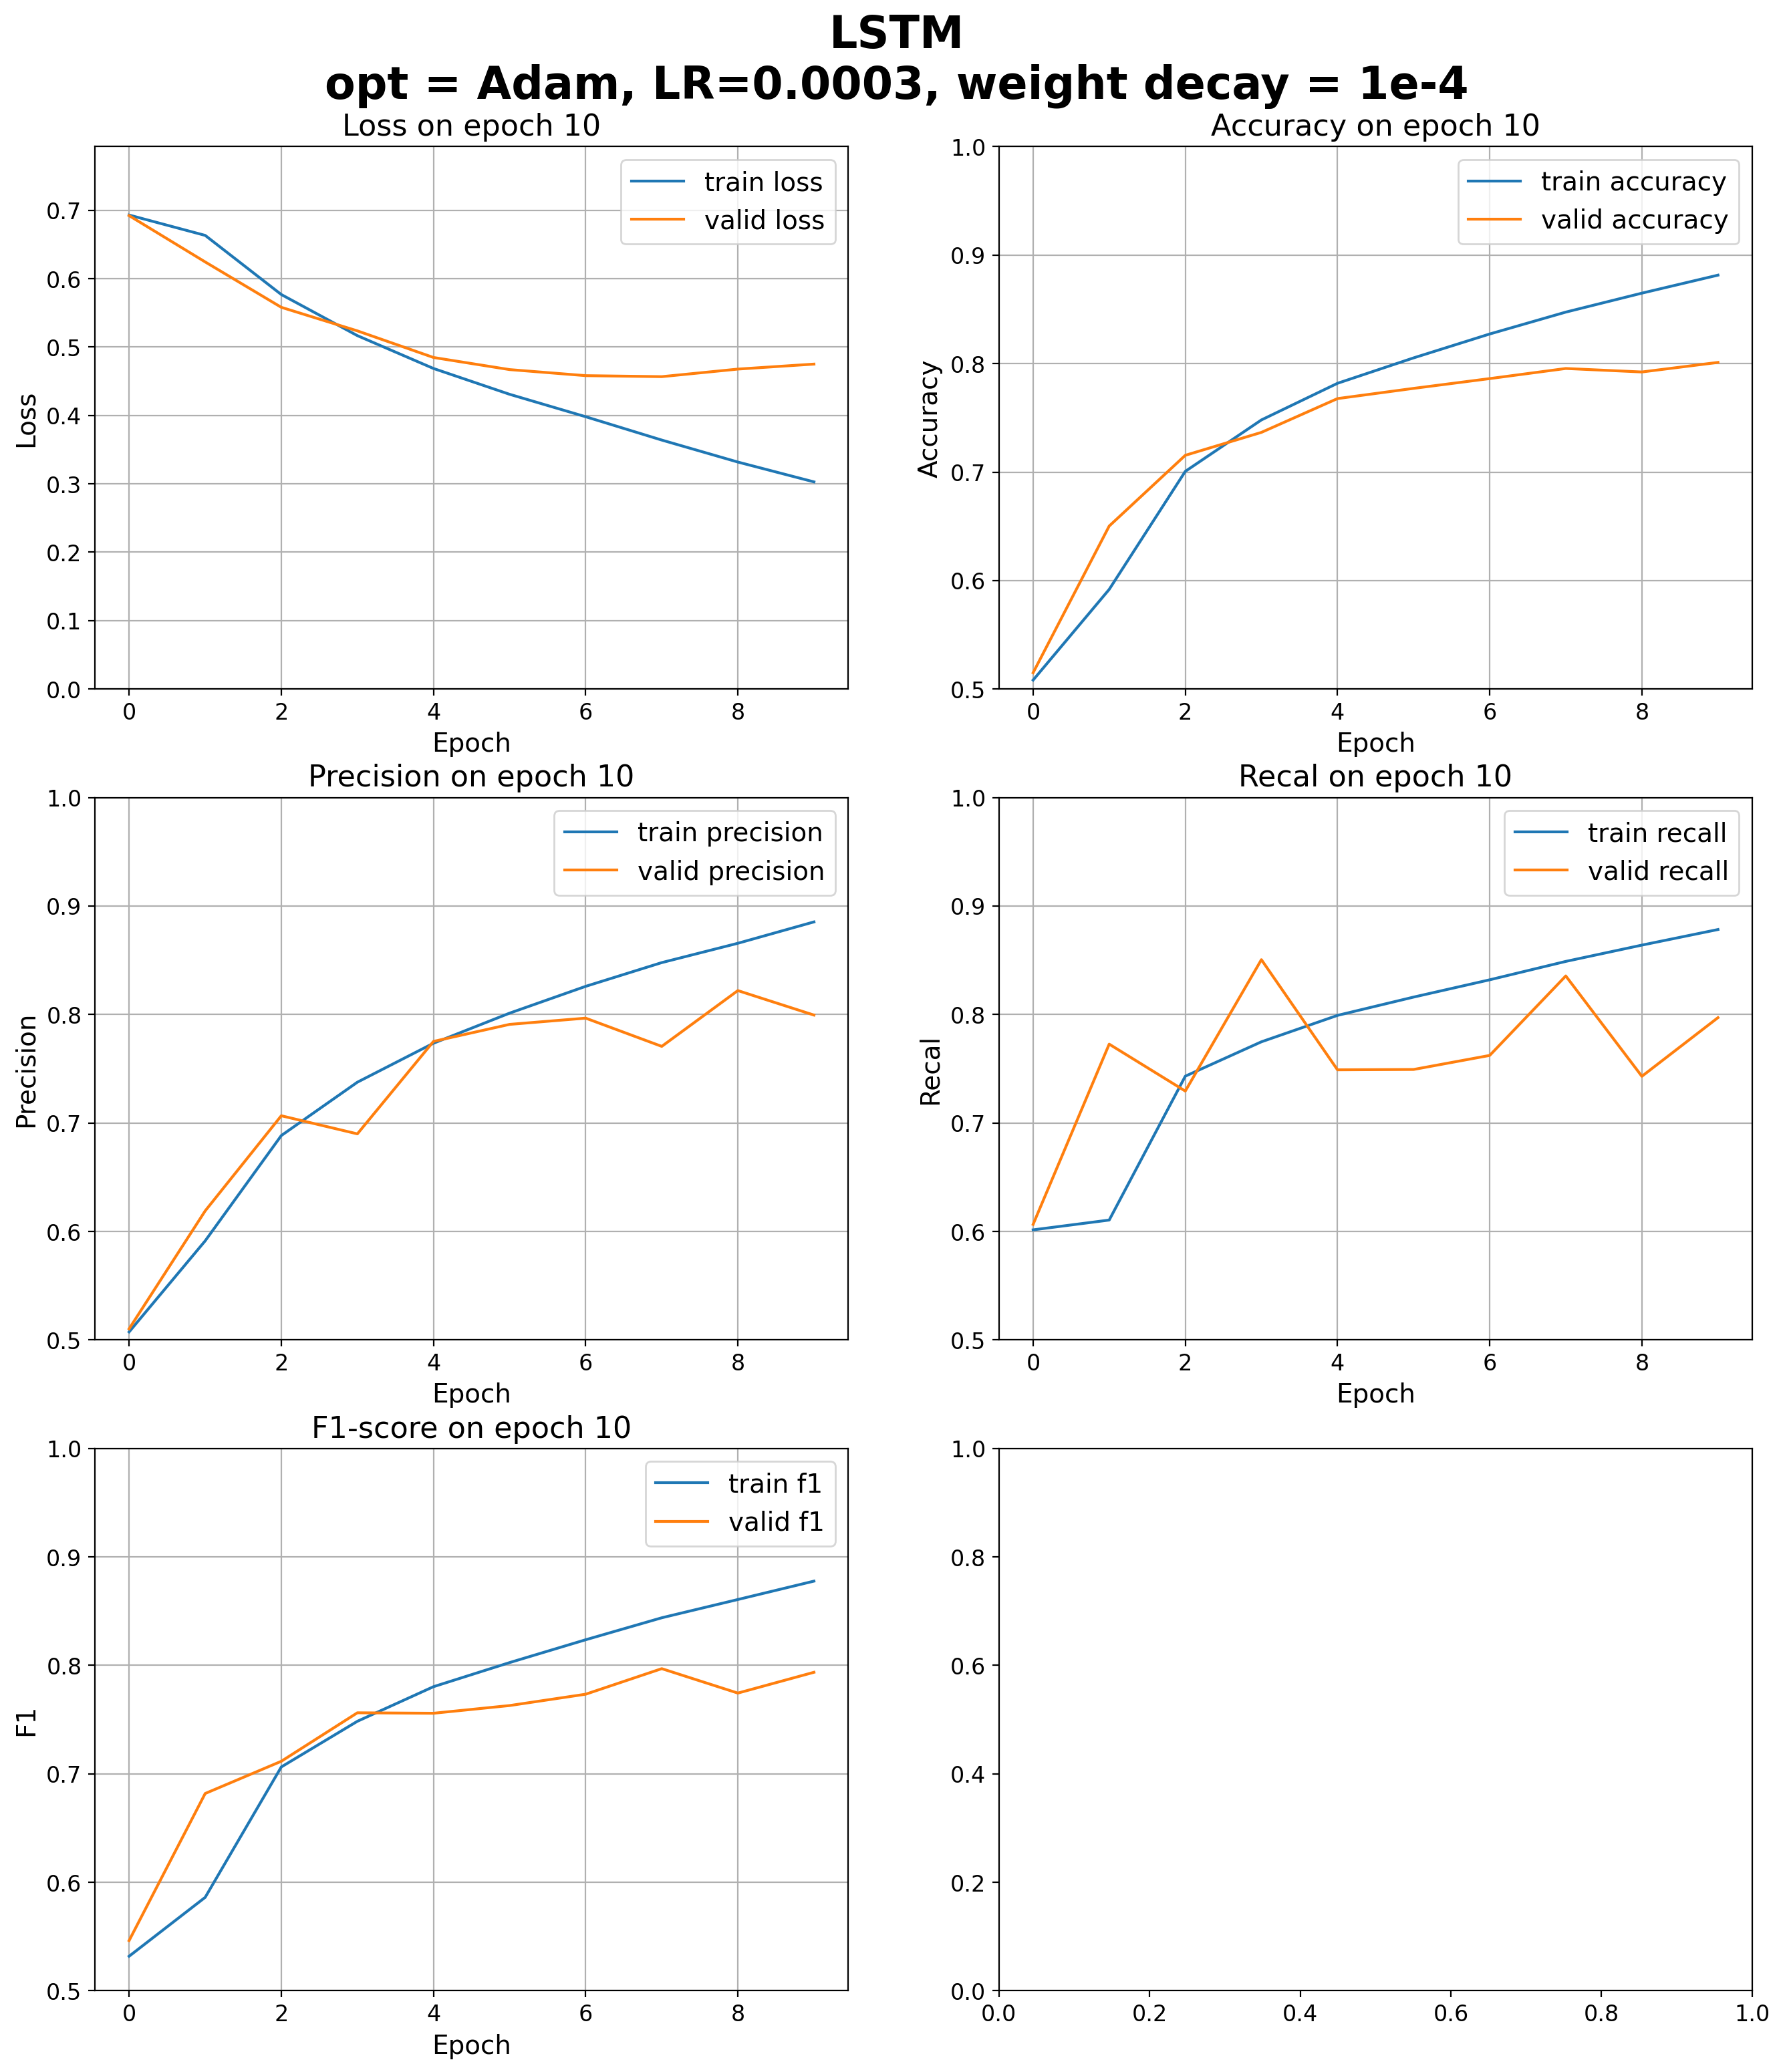

In [67]:
fig_2 = plot_history(
    logs_lstm, suptitle=f"LSTM\nopt = Adam, LR={LR_LSTM}, weight decay = 1e-4"
)

In [68]:
fig_2.savefig(f"results/LSTM_run_{run_lstm}.png", bbox_inches="tight")

Text(0, 0.5, 'Accuracy')

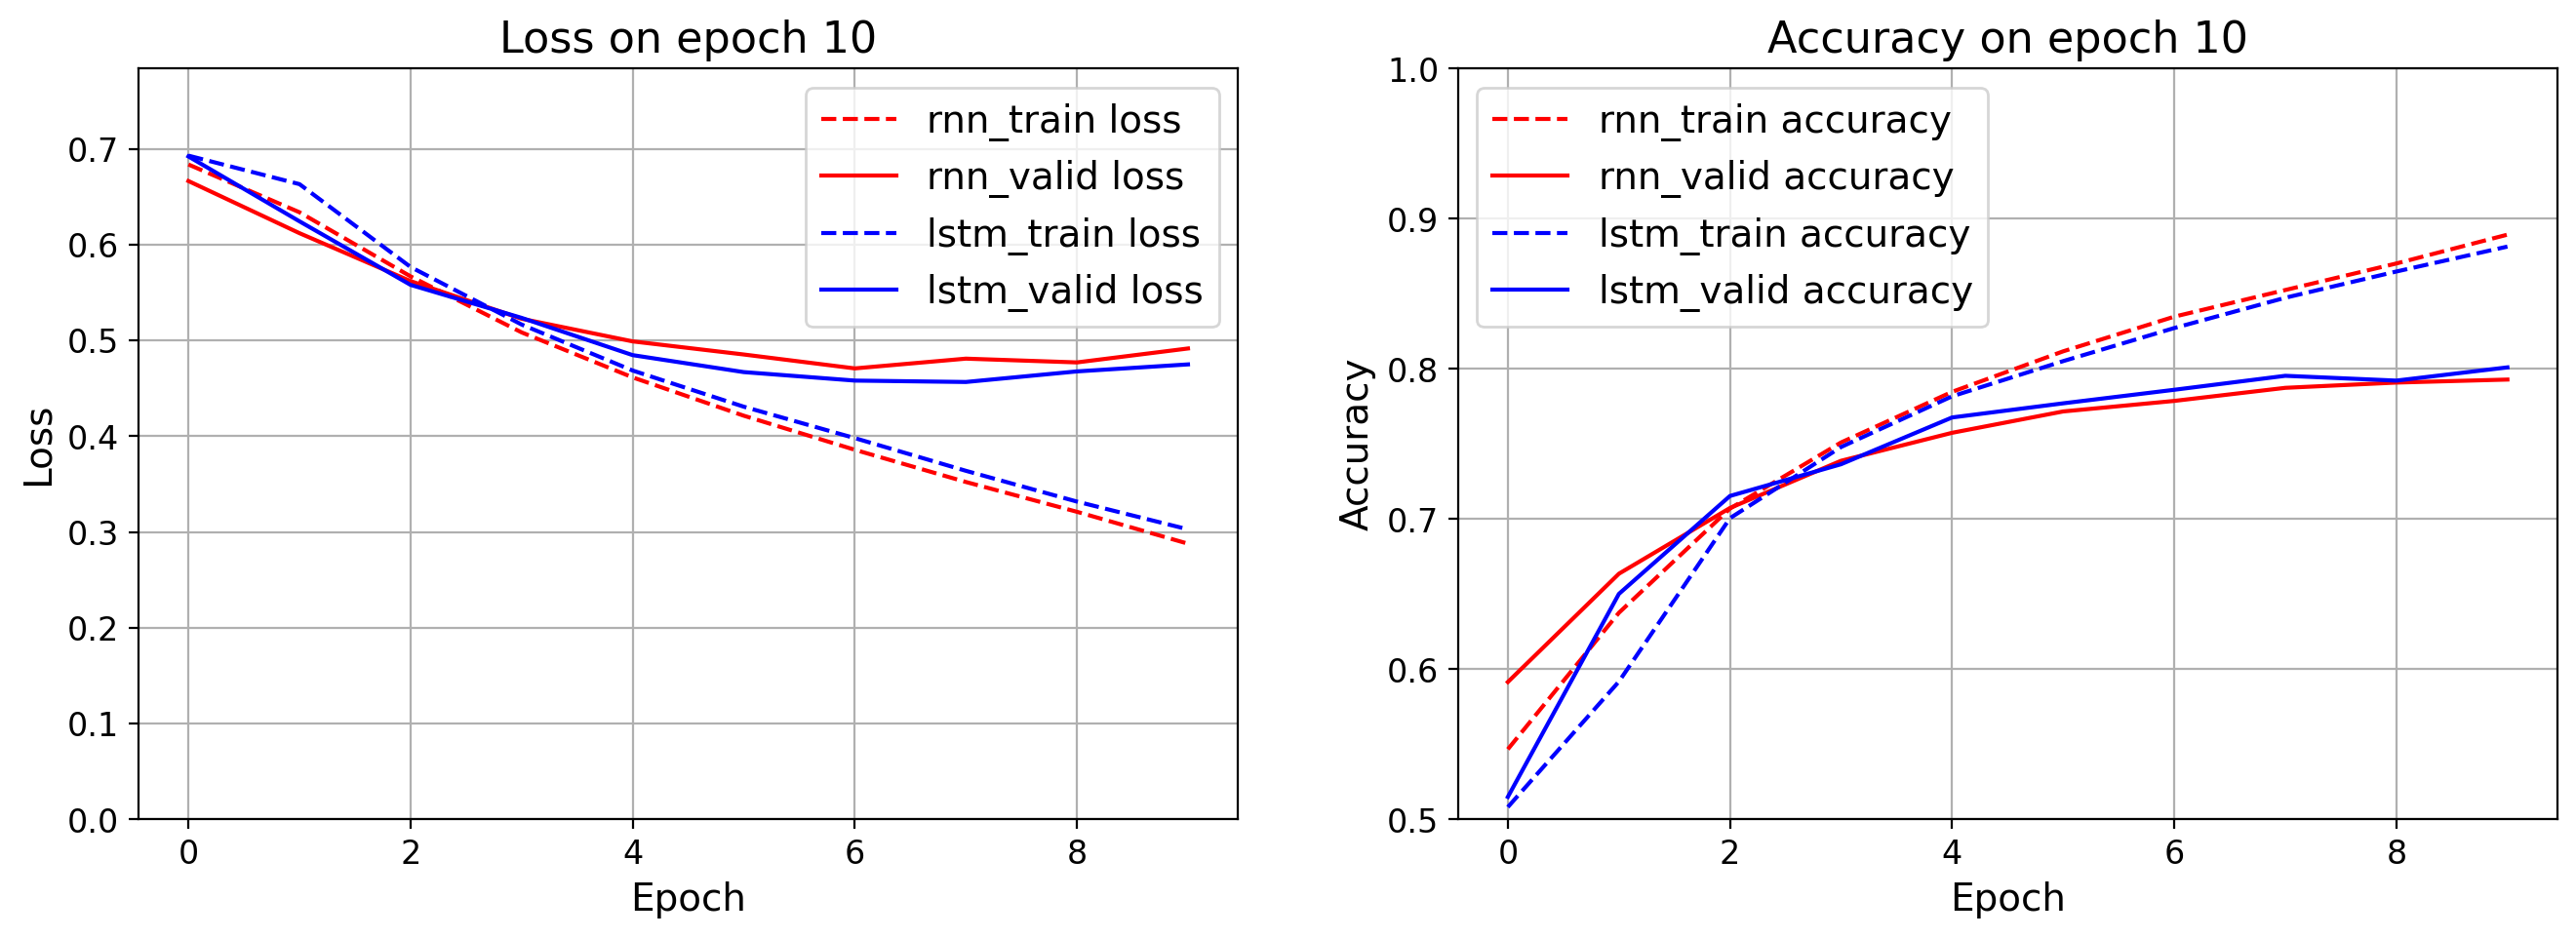

In [75]:
fig3, ax = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("RNN-LSTM compare", fontsize=24, fontweight="bold", y=0.85)
ax[0].plot(logs["train_loss"], label="rnn_train loss", linestyle="--", color="red")
ax[0].plot(logs["valid_loss"], label="rnn_valid loss", color="red")
ax[0].plot(
    logs_lstm["train_loss"], label="lstm_train loss", linestyle="--", color="blue"
)
ax[0].plot(logs_lstm["valid_loss"], label="lstm_valid loss", color="blue")
ax[0].set_title(f'Loss on epoch {len(logs["train_loss"])}', fontsize=16)
ax[0].grid(True)
ax[0].set_ylim((0, max(logs["train_loss"] + logs["valid_loss"]) + 0.1))
ax[0].legend(fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)
ax[0].set_ylabel("Loss", fontsize=14)

ax[1].plot(
    logs["train_accuracy"], label="rnn_train accuracy", linestyle="--", color="red"
)
ax[1].plot(logs["valid_accuracy"], label="rnn_valid accuracy", color="red")
ax[1].plot(
    logs_lstm["train_accuracy"],
    label="lstm_train accuracy",
    linestyle="--",
    color="blue",
)
ax[1].plot(logs_lstm["valid_accuracy"], label="lstm_valid accuracy", color="blue")
ax[1].set_title(f'Accuracy on epoch {len(logs["train_loss"])}', fontsize=16)
ax[1].grid(True)
# ax[0][1].set_ylim((min(history["train_accuracy"]) - 0.05, 1))
ax[1].set_ylim(0.5, 1)
ax[1].legend(fontsize=14)
ax[1].set_xlabel("Epoch", fontsize=14)
ax[1].set_ylabel("Accuracy", fontsize=14)

In [ ]:
# fig3.savefig("results/RNN_LSTM_compare")

#### Задание 2.1

Попробуй обрезать отзывы до максимальной длины с другой стороны. В функции `padding` в случае превышения отзывом порога `seq_len` происходит обрезка – остаются только первые `seq_len` слов. Возможно, что стоит обрезать сообщения с другой стороны (оставлять только «хвост» отзыва)? 

Попробуй модифицировать функцию, обучи модель и проверь, отличается ли результат. 

In [54]:
def padding_reverse(review_int: list, seq_len: int) -> np.array:
    """Make left-sided padding for input list of tokens

    Args:
        review_int (list): input list of tokens
        seq_len (int): max length of sequence, it len(review_int[i]) > seq_len it will be trimmed, else it will be padded by zeros

    Returns:
        np.array: padded sequences
    """
    features = np.zeros((len(reviews_int), seq_len), dtype=int)
    for i, review in enumerate(review_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[len(review) - seq_len :]
        features[i, :] = np.array(new)

    return features

In [55]:
features_2 = padding_reverse(reviews_int, SEQ_LEN)
print(len(features[3, :]) != 32)

False


In [56]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(
    features_2, df["sentiment"].to_numpy(), test_size=0.2, random_state=1
)

In [57]:
X_train_2.shape
X_valid_2.shape

(10000, 32)

In [58]:
train_data_2 = TensorDataset(torch.from_numpy(X_train_2), torch.from_numpy(y_train_2))
valid_data_2 = TensorDataset(torch.from_numpy(X_valid_2), torch.from_numpy(y_valid_2))


BATCH_SIZE = 32

train_loader_2 = DataLoader(
    train_data_2,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)
valid_loader_2 = DataLoader(
    valid_data_2,
    shuffle=True,
    batch_size=BATCH_SIZE,
    drop_last=True,
    num_workers=4,
    pin_memory=True,
    generator=GENERATOR,
)

In [60]:
model_lstm_2 = LSTMClassifier().to(DEVICE)

In [62]:
LR_LSTM_2 = 3e-4
criterion_lstm_2 = nn.BCEWithLogitsLoss()
optimizer_lstm_2 = torch.optim.Adam(
    model_lstm_2.parameters(), lr=LR_LSTM_2, weight_decay=1e-4
)

In [63]:
logs_lstm_2, train_time_lstm_2, run_lstm_2 = fit_with_mlflow(
    model=model_lstm_2,
    model_name="LSTM_2",
    epochs=10,
    optimizer=optimizer_lstm_2,
    experiment_name="LSTM_2",
    criterion=criterion_lstm_2,
    train_loader=train_loader_2,
    valid_loader=valid_loader_2,
)

2025/09/22 17:02:56 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_2' does not exist. Creating a new experiment.


начало обучения...
------------- Epoch 1 -------------


Epoch 1/10 [Test]: 100%|██████████| 312/312 [00:03<00:00, 86.45it/s] 


Train stage: loss:  0.681  Accuracy:  0.549  Precision:  0.554  Recall:  0.530  F1-score:  0.524  
Valid stage: loss:  0.646  Accuracy:  0.627  Precision:  0.606  Recall:  0.721  F1-score:  0.652  
Time: 17.498326063156128
-----------------------------------

------------- Epoch 2 -------------


Epoch 2/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 76.62it/s] 


Train stage: loss:  0.600  Accuracy:  0.677  Precision:  0.677  Recall:  0.691  F1-score:  0.673  
Valid stage: loss:  0.562  Accuracy:  0.708  Precision:  0.660  Recall:  0.841  F1-score:  0.734  
Time: 18.46101474761963
-----------------------------------

------------- Epoch 3 -------------


Epoch 3/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 64.31it/s] 


Train stage: loss:  0.518  Accuracy:  0.746  Precision:  0.747  Recall:  0.755  F1-score:  0.742  
Valid stage: loss:  0.495  Accuracy:  0.755  Precision:  0.771  Recall:  0.718  F1-score:  0.737  
Time: 19.592655420303345
-----------------------------------

------------- Epoch 4 -------------


Epoch 4/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 75.54it/s] 


Train stage: loss:  0.464  Accuracy:  0.781  Precision:  0.782  Recall:  0.785  F1-score:  0.776  
Valid stage: loss:  0.458  Accuracy:  0.782  Precision:  0.789  Recall:  0.767  F1-score:  0.772  
Time: 18.881346702575684
-----------------------------------

------------- Epoch 5 -------------


Epoch 5/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 74.52it/s] 


Train stage: loss:  0.424  Accuracy:  0.809  Precision:  0.809  Recall:  0.811  F1-score:  0.804  
Valid stage: loss:  0.445  Accuracy:  0.792  Precision:  0.754  Recall:  0.862  F1-score:  0.800  
Time: 18.75562286376953
-----------------------------------

------------- Epoch 6 -------------


Epoch 6/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 75.64it/s] 


Train stage: loss:  0.389  Accuracy:  0.828  Precision:  0.826  Recall:  0.833  F1-score:  0.825  
Valid stage: loss:  0.418  Accuracy:  0.809  Precision:  0.825  Recall:  0.782  F1-score:  0.797  
Time: 18.42978310585022
-----------------------------------

------------- Epoch 7 -------------


Epoch 7/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 75.63it/s] 


Train stage: loss:  0.359  Accuracy:  0.846  Precision:  0.846  Recall:  0.850  F1-score:  0.843  
Valid stage: loss:  0.412  Accuracy:  0.814  Precision:  0.838  Recall:  0.770  F1-score:  0.798  
Time: 18.261802196502686
-----------------------------------

------------- Epoch 8 -------------


Epoch 8/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 71.74it/s] 


Train stage: loss:  0.329  Accuracy:  0.862  Precision:  0.861  Recall:  0.866  F1-score:  0.859  
Valid stage: loss:  0.397  Accuracy:  0.823  Precision:  0.817  Recall:  0.831  F1-score:  0.819  
Time: 19.090985536575317
-----------------------------------

------------- Epoch 9 -------------


Epoch 9/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 74.48it/s] 


Train stage: loss:  0.302  Accuracy:  0.877  Precision:  0.877  Recall:  0.879  F1-score:  0.874  
Valid stage: loss:  0.396  Accuracy:  0.827  Precision:  0.818  Recall:  0.837  F1-score:  0.822  
Time: 19.094144344329834
-----------------------------------

------------- Epoch 10 -------------


Epoch 10/10 [Test]: 100%|██████████| 312/312 [00:04<00:00, 74.92it/s] 


Train stage: loss:  0.275  Accuracy:  0.893  Precision:  0.892  Recall:  0.895  F1-score:  0.890  
Valid stage: loss:  0.424  Accuracy:  0.823  Precision:  0.795  Recall:  0.867  F1-score:  0.825  
Time: 18.41950011253357
-----------------------------------

Total time = 186.6 сек
🏃 View run LSTM_2_BS = 32_lr_0.0003 at: http://localhost:5000/#/experiments/545522664505090151/runs/5d1762e7b0cd49c7ad34d8e789d3677e
🧪 View experiment at: http://localhost:5000/#/experiments/545522664505090151


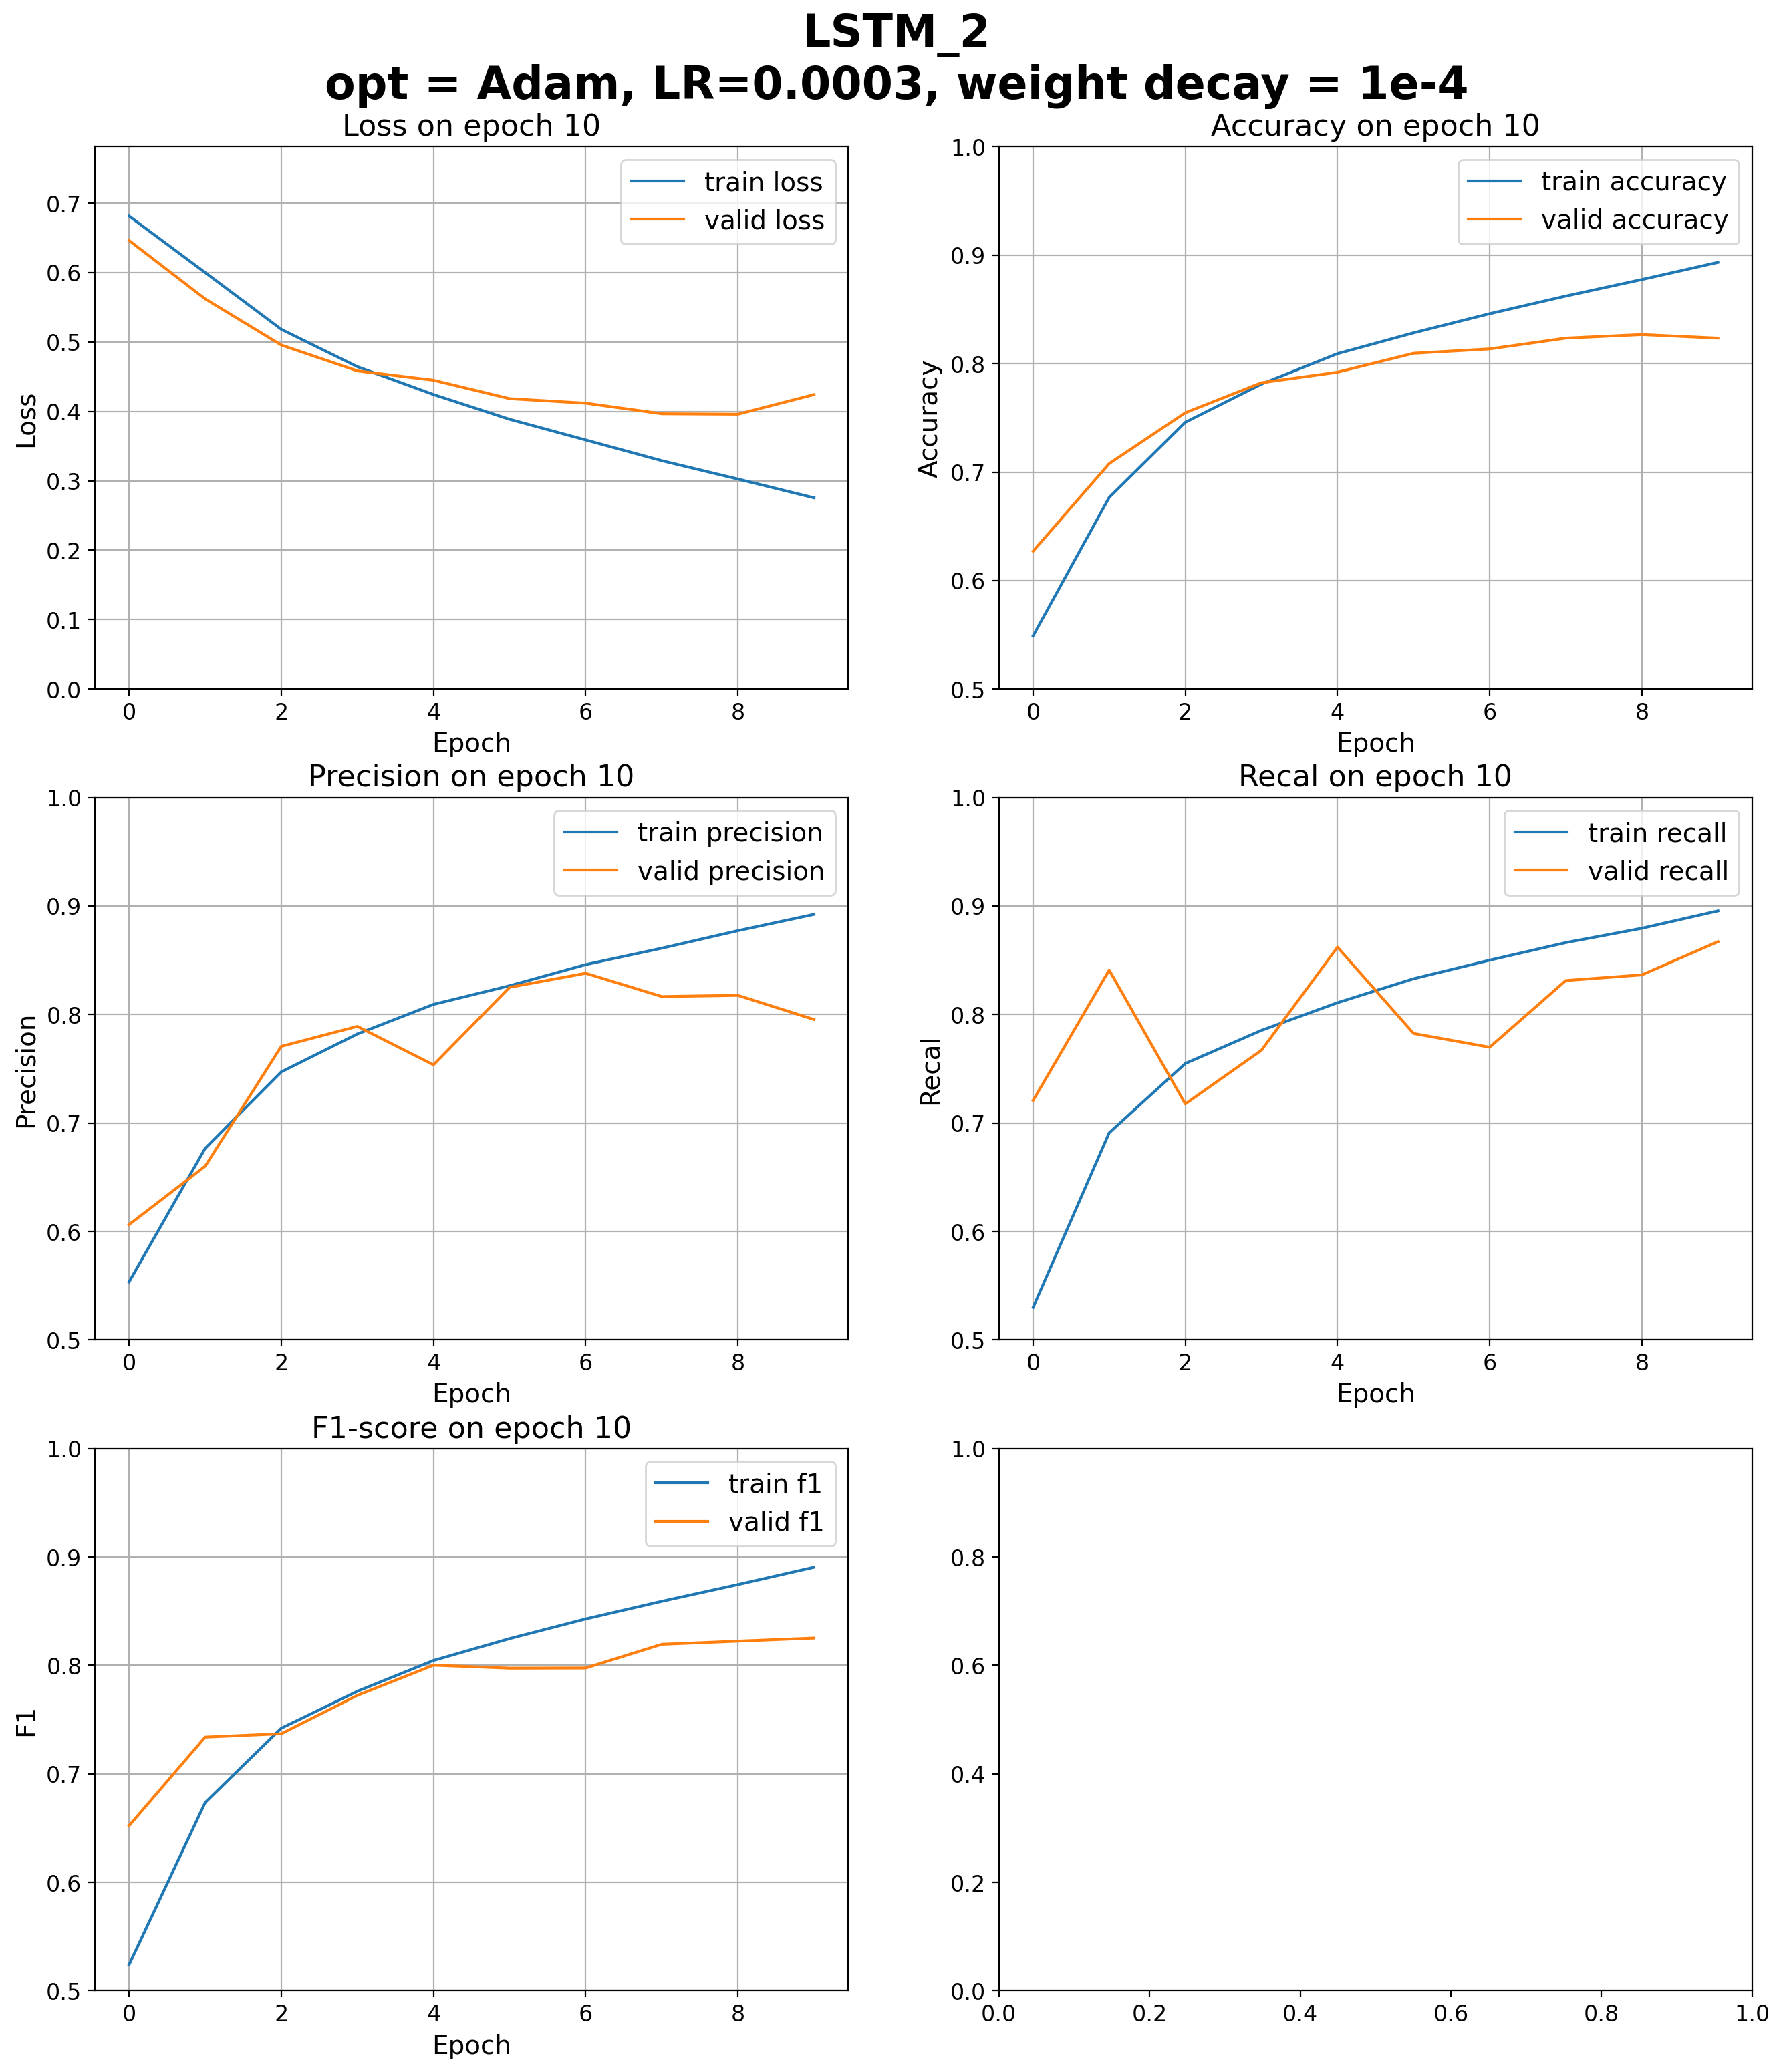

In [69]:
fig_4 = plot_history(
    logs_lstm_2, suptitle=f"LSTM_2\nopt = Adam, LR={LR_LSTM_2}, weight decay = 1e-4"
)

In [ ]:
# fig_4.savefig(f"results/LSTM_2_run_{run_lstm_2}.png", bbox_inches="tight")

#### Задание 3

Реализуй функцию, которая принимает на вход текстовое сообщение и классифицирует его обученной моделью. 

In [116]:
def predict_sentence(text: str, model: nn.Module, weights: str) -> str:
    input = preprocess_single_string(text, seq_len=SEQ_LEN).unsqueeze(0)
    state_dict = torch.load(weights, map_location="cpu")
    model.to("cpu")
    model.load_state_dict(state_dict)
    model.eval()
    output = model(input)
    with torch.inference_mode():
        prob = output.squeeze().sigmoid().item()
    if prob > 0.5:
        Class = 1
        result = "Positive feedback"
    else:
        Class = 0
        result = "Negative feedback"
    return Class, prob, result

In [114]:
test_weights = "weights/LSTM_2/run_1/weight_epoch_7.pth"
# test_sent = df.loc[np.random.randint(0, df.shape[0]), "review"]
# print(test_sent)

In [ ]:
# predict_sentence(test_sent, model_lstm_2, test_weights)

'Class = 1 (p=0.97): Positive feedback'

In [126]:
n = 10
rand_reviews = df["review"].sample(n=10, random_state=42)
rand_reviews = rand_reviews.reset_index()
rand_reviews["Class"] = rand_reviews["review"].map(
    lambda x: predict_sentence(x, model_lstm_2, test_weights)[0]
)
rand_reviews["Probability"] = rand_reviews["review"].map(
    lambda x: predict_sentence(x, model_lstm_2, test_weights)[1]
)
rand_reviews["Result"] = rand_reviews["review"].map(
    lambda x: predict_sentence(x, model_lstm_2, test_weights)[2]
)
rand_reviews["True_label"] = pd.Series(
    [df.loc[c, "sentiment"] for c in rand_reviews["index"]]
)
# rand_reviews.drop("index", inplace=True, axis=1)
rand_reviews

index                                             review  Class  \
0  33553  I really liked this Summerslam due to the look...      0   
1   9427  Not many television shows appeal to quite as m...      1   
2    199  The film quickly gets to a major chase scene w...      0   
3  12447  Jane Austen would definitely approve of this o...      1   
4  39489  Expectations were somewhat high for me when I ...      0   
5  42724  I've watched this movie on a fairly regular ba...      1   
6  10822  For once a story of hope highlighted over the ...      1   
7  49498  Okay, I didn't get the Purgatory thing the fir...      0   
8   4144  I was very disappointed with this series. It h...      0   
9  36958  The first 30 minutes of Tinseltown had my fing...      0   

   Probability             Result  True_label  
0     0.139486  Negative feedback           1  
1     0.807064  Positive feedback           1  
2     0.022207  Negative feedback           0  
3     0.946753  Positive feedback           1  
4     0.481118  Negative feedback           0  
5     0.512082  Positive feedback           1  
6     0.977746  Positive feedback           1  
7     0.296603  Negative feedback           1  
8     0.493411  Negative feedback           0  
9     0.054536  Negative feedback           0

In [123]:
print(rand_reviews.loc[4, "review"])
print(df.loc[39489, "sentiment"])

Expectations were somewhat high for me when I went to see this movie, after all I thought Steve Carell could do no wrong coming off of great movies like Anchorman, The 40 Year-Old Virgin, and Little Miss Sunshine. Boy, was I wrong.<br /><br />I'll start with what is right with this movie: at certain points Steve Carell is allowed to be Steve Carell. There are a handful of moments in the film that made me laugh, and it's due almost entirely to him being given the wiggle-room to do his thing. He's an undoubtedly talented individual, and it's a shame that he signed on to what turned out to be, in my opinion, a total train-wreck.<br /><br />With that out of the way, I'll discuss what went horrifyingly wrong.<br /><br />The film begins with Dan Burns, a widower with three girls who is being considered for a nationally syndicated advice column. He prepares his girls for a family reunion, where his extended relatives gather for some time with each other.<br /><br />The family is high atop the

In [ ]:
print(rand_reviews.loc[5, "review"])
print(df.loc[42724, "sentiment"])

❗️ Сделай push на гитхаб!

In [ ]:
# code

#### Задание 4

Создай telegram-бота, который принимает на вход пользовательское сообщение и классифицирует его. 